In this notebook we learn about how to scale Dp solutions using Apache Beam Pipeline on huge datasets. This is taken from 
https://github.com/OpenMined/PipelineDP/tree/main/examples

# Scaling Differential Privacy solutions with Apache Beam Pipeline 

### Set-Up
Install dependencies, import libraries and set plotting style


In [1]:
!pip install pipeline-dp apache-beam
from IPython.display import clear_output

clear_output()

In [2]:
import apache_beam as beam
from apache_beam.runners.portability import fn_api_runner
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.interactive.interactive_beam import *
from dataclasses import dataclass

import functools
from IPython import display
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pipeline_dp
import pipeline_dp.private_beam as pbeam
import seaborn as sns

In [3]:
## https://matplotlib.org/users/style_sheets.html
## https://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template

file_contents = """
axes.grid: False
axes.labelsize: large
axes.axisbelow: True

# Google Blue, Red, Green, Yellow, Grey
# https://material.googleplex.com/style/color.html#color-google-color-palette-guidelines
axes.prop_cycle: cycler('color', ['4285F4', 'DB4437', '0F9D58', 'F4B400', '9E9E9E', 'D2691E', 'FF6347', '87CEEB', 'FFC0CB', '32CD32', 'DA70D6', '808000', 'FFD700'])

font.size: 14
font.family: sans-serif

legend.fontsize: large
legend.fancybox: True
legend.facecolor: FAFBFC
legend.frameon: True
legend.loc: best
"""

# Use a tempfile because matplotlib has to load a file by name or URL
import tempfile
f = tempfile.NamedTemporaryFile(delete=False)
name = f.name
f.write(file_contents.encode())
f.close()

# Load the style sheet
# plt.style.use(name)
plt.style.use(['seaborn-talk', name])
colors=['#4285F4', '#DB4437', '#0F9D58', '#F4B400', '#9E9E9E', '#D2691E', '#FF6347',
        '#87CEEB', '#FFC0CB', '#32CD32', '#DA70D6', '#808000', '#FFD700']
sns.set_palette(sns.color_palette(colors))
# Make plots bigger
# plt.rcParams["figure.figsize"] = (8, 8)

# Make plots higher resolution
%config InlineBackend.figure_format='retina'

In [4]:
#@title Define helper functions for plotting
def grouped_bar_chart(group_1: pd.DataFrame, group_2:pd.DataFrame, ax:plt.Axes):
  """Generates a grouped bar char and returns it.

  Args:
    group_1: The data of the first group to plot.
    group_2: The data of the second group to plot.
    ax: The ax object to manipulate.
  """
  labels = group_1['product_view_0']
  not_converted_counts = group_1['conversion_value']
  converted_counts = group_2['conversion_value']
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  rects1 = ax.bar(
      x - width / 2,
      not_converted_counts,
      width,
      label='has converted',
      color=colors[0])
  rects2 = ax.bar(
      x + width / 2,
      converted_counts,
      width,
      label='has not converted',
      color=colors[1])

  ax.set_ylim(bottom=0, top=50)
  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of visitors')
  ax.set_xlabel('First product viewed')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  return ax, rects1, rects2

def private_result_to_df(dp_result: list, metrics: list):
  """Creates a DataFrame from the differentially private results.

  Args:
    dp_result: Result of the differentially private aggregation.
    metrics: Metrics contained in the result.
  """
  index = [result[0] for result in dp_result]
  statistics = [result[1] for result in dp_result]
  return pd.DataFrame(statistics, index=index, columns=metrics)


def plot_private_and_standard_statistics(df: pd.DataFrame,
                                         dp_result: pd.DataFrame,
                                         private_metric_name: str,
                                         original_metric_name: str,
                                         ax: plt.Axes,
                                         y_label: str):
  """Generates a barchart to compare private and non-private statistics.

  Args:
    df: Original data.
    dp_result: Result of the differentially-private aggregation.
    private_metric_name: Column name of the private metric.
    original_metric_name: Column name of the non-private metric.
    ax: Object to plot on.
    y_label: Label of y-axis. 
  """
  (pd.merge(
      df,
      dp_result[private_metric_name],
      left_index=True,
      right_index=True,
      how='outer')).rename(
          columns={
              original_metric_name: f'non-private {private_metric_name}',
              private_metric_name: f'differentially private {private_metric_name}'
          }).plot(
              kind='bar', ax=ax)
  ax.legend(bbox_to_anchor=[1, 0.9])
  ax.set_ylabel(y_label)
  ax.set_xlabel('First product viewed')
  return ax

In [5]:
EPSILON = 1 #@param
DELTA = 1e-5 #@param

# Compute private statistics with PipelineDP

Authors: Christiane Ahlheim, Mirac Vuslat Basaran, Vadym Doroshenko, Miguel Guevera, Yurii Sushko


 # Before you begin

Duration: 2:00

You might think that aggregate statistics don’t leak any information about the individuals to whom they pertain. However, there are many ways that an attacker can learn sensitive information about individuals from aggregate statistics.

In this codelab, you learn how to produce private statistics with differentially private aggregations from PipelineDP to protect individuals' privacy. PipelineDP is a Python framework that lets you apply differential privacy to large datasets with batch-processing systems, such as [Apache Spark](https://spark.apache.org/) and [Apache Beam](https://beam.apache.org/). For more information about how to compute differentially private statistics in [Go](https://go.dev/), see the [Privacy on Beam](https://codelabs.developers.google.com/codelabs/privacy-on-beam#0) codelab.

_Private_ means that the output is produced in a way that doesn't leak any private information about the individuals in the data. You can achieve this outcome through _differential privacy_, a strong privacy notion of _anonymization_, which is the process of data aggregation across multiple users to protect user privacy. All anonymization methods use aggregation, but not all aggregation methods achieve anonymization. Differential privacy, on the other hand, provides measurable guarantees about information leakage and privacy.

## Prerequisites 
* Familiarity with Python
* Familiarity with basic data aggregation
* Experience with pandas, Spark, and Beam

## What you'll learn
* The basics of differential privacy
* How to calculate differentially private summary statistics with PipelineDP
* How to tweak your results with additional privacy and utility parameters

## What you'll need 
* If you want to run the codelab in your own environment, you need Python 3.7 or higher installed on your computer.
* If you want to follow the codelab without your own environment, you need access to [Colaboratory](https://colab.sandbox.google.com/?utm_source=scs-index).



# Understand differential privacy

Duration: 2:00

To better understand differential privacy, look at this simple example.

Imagine that you work in the marketing department of an online fashion retailer and you want to understand which of your products are most likely to sell. 

This chart shows which products the customers looked at first when they visited the shop’s website: t-shirts, jumpers, socks, or jeans. T-shirts are the most popular item while socks are the least popular item.

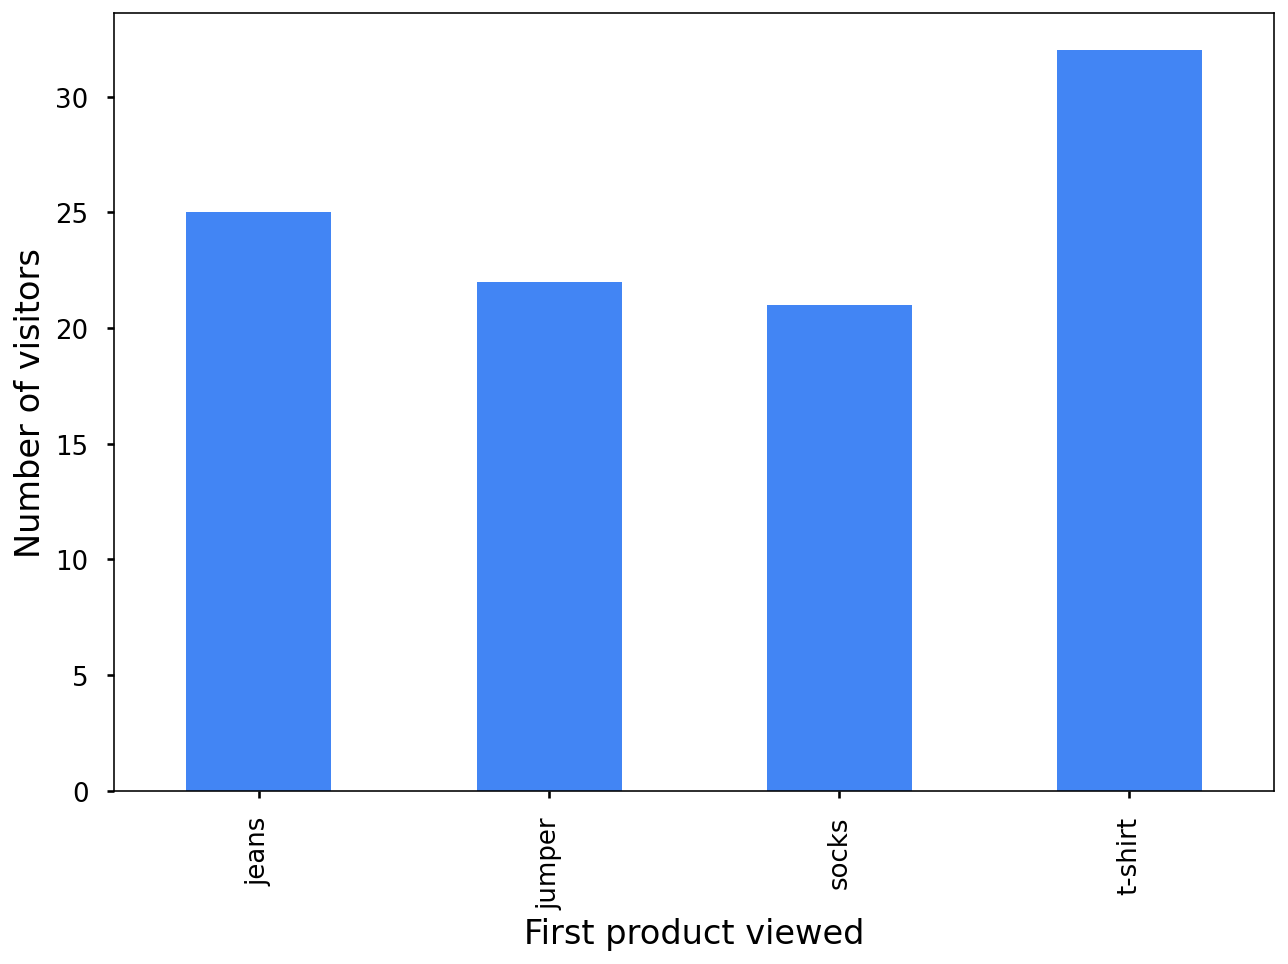

In [6]:
#@title
df = pd.read_csv(
    'https://raw.githubusercontent.com/OpenMined/PipelineDP/main/examples/codelab/synthetic_customer_journeys.csv',
    index_col=0)
ax = df['product_view_0'].value_counts().sort_index().plot(kind='bar')
ax.set_ylabel('Number of visitors')
ax.set_xlabel('First product viewed')

plt.show()

This looks useful, but there’s a catch. When you want to take additional information into account, such as whether customers made a purchase or which product they viewed second, you risk revealing individuals in your data. 

This chart shows you that only one customer looked at a jumper first and then actually made a purchase:


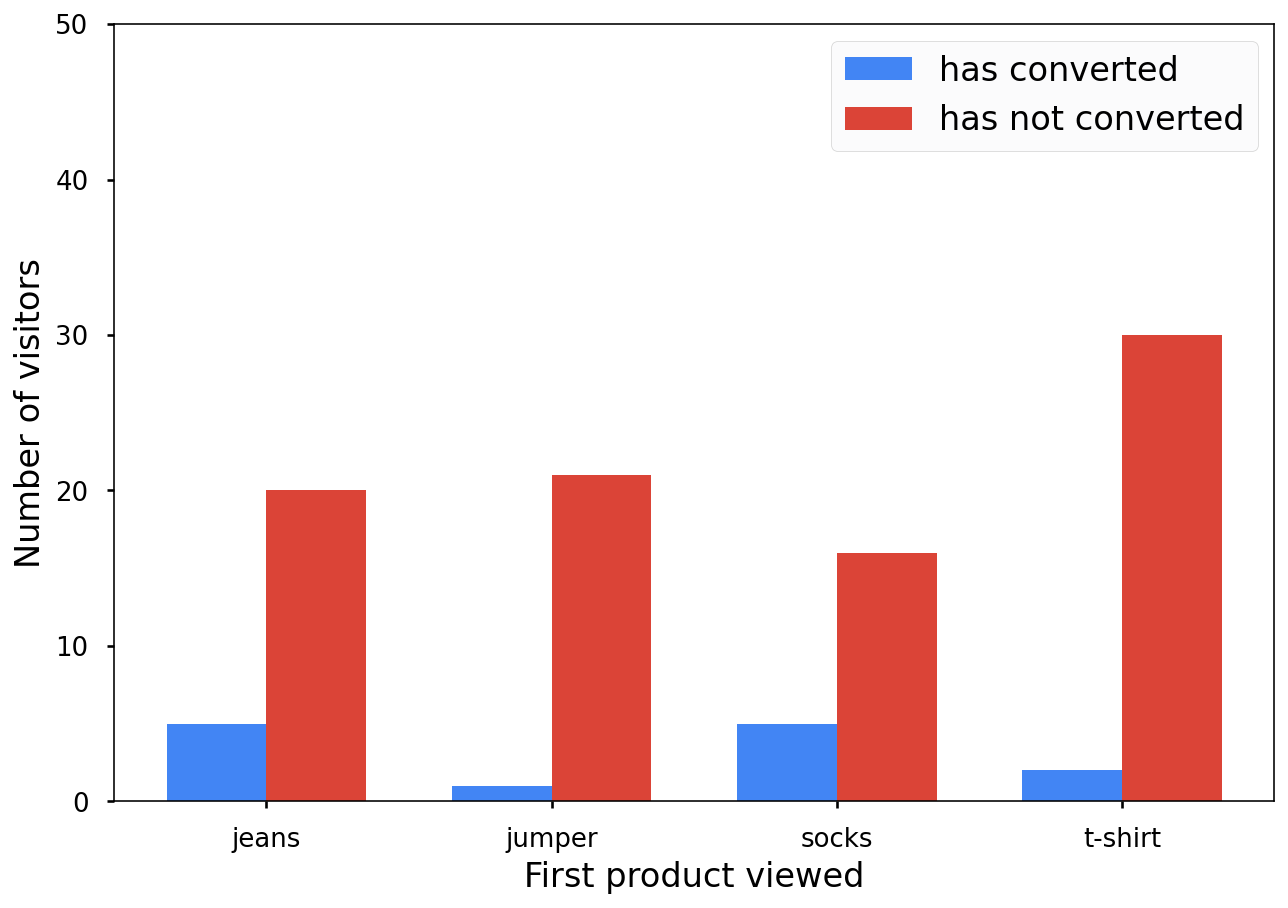

In [7]:
#@title
df_grouped_conversion_counts = pd.DataFrame(
    df.groupby(['product_view_0',
                'has_conversion'])['conversion_value'].count().reset_index())

fig, ax = plt.subplots()
ax, _, _ = grouped_bar_chart(
    df_grouped_conversion_counts[df_grouped_conversion_counts['has_conversion']
                                 == True],
    df_grouped_conversion_counts[df_grouped_conversion_counts['has_conversion']
                                 == False],
    ax=ax)
ax.legend()
plt.show()

This isn’t great from a privacy perspective. Anonymized statistics shouldn’t reveal individual contributions, so what do you do? You add random noise to your bar charts to make them a bit less accurate!

This bar chart isn't _entirely_ accurate, but it's still useful and it doesn't reveal individual contributions:

In [8]:
#@title
fig, ax = plt.subplots()
ax, rects1, rects2 = grouped_bar_chart(
    df_grouped_conversion_counts[df_grouped_conversion_counts['has_conversion']
                                 == True],
    df_grouped_conversion_counts[df_grouped_conversion_counts['has_conversion']
                                 == False],
                                 ax=ax)
ax.legend()

def animate(frame):
  """Function to create animations."""
  rng = np.random.default_rng()
  noise = rng.laplace(size=len(df_grouped_conversion_counts), scale=1)

  heights_no_conversion = df_grouped_conversion_counts[
      df_grouped_conversion_counts['has_conversion'] ==
      False]['conversion_value'].values

  heights_conversion = df_grouped_conversion_counts[
      df_grouped_conversion_counts['has_conversion'] ==
      True]['conversion_value'].values
      
  for index, b in enumerate(rects1):
    b.set_height(heights_conversion[index]+ noise[index])

  noise = rng.laplace(size=len(df_grouped_conversion_counts), scale=1)
  for index, b in enumerate(rects2):
    b.set_height(heights_no_conversion[index] + noise[index])

ani = matplotlib.animation.FuncAnimation(
    fig,
    animate,
    frames=200,
    interval=10,
    repeat=True,
    blit=False)
plt.close()

html = display.HTML(ani.to_html5_video())
display.display(html)

_Differential privacy is the addition of the right amount of random noise to mask individual contributions._

This example is oversimplified. The proper implementation of differential privacy is more involved and comes with a number of unexpected implementation subtleties. Similar to cryptography, it might not be a great idea to create your own implementation of differential privacy. Instead, you can use PipelineDP.

# Download and install PipelineDP

Duration: 1:00

You don’t need to install PipelineDP follow this codelab because you can find all the relevant code and graphs in this document. 

To play with PipelineDP, run it yourself, or use it later:



* Download and install PipelineDP:

```
pip install pipeline-dp
```

If you want to run the example using Apache Beam, download and install Apache Beam:

```
pip install apache_beam
```




You can find the code for this codelab and the dataset in the `PipelineDP/examples/codelab/` directory.

# Compute conversion metrics per first product viewed 
Duration: 10:00

Imagine that you work at an online fashion retailer and you want to understand which of your different product categories generate the highest number and value of conversions when viewed first. You want to share this information with your marketing agency as well as other internal teams, but you want to prevent the leak of information about any individual customer.

To compute conversion metrics per first product viewed for the website:



1. Review the mock dataset of visits to your website in the `PipelineDP/examples/codelab/` directory.

    This screenshot is an example of the dataset. It contains the user's ID, the products that a user viewed, whether the visitor converted, and, if so, the value of the conversion.

In [9]:
#@title
df.head()

,conversion_value,product_view_0,product_view_1,product_view_2,product_view_3,product_view_4,has_conversion,user_id
0,0.00,jeans,t-shirt,t-shirt,none,none,False,0
1,0.00,jeans,t-shirt,jeans,jumper,none,False,1
2,105.19,t-shirt,jumper,t-shirt,t-shirt,none,True,2
3,0.00,t-shirt,t-shirt,jeans,none,none,False,3
4,0.00,t-shirt,socks,jeans,jeans,none,False,4


You're interested in these metrics:

* `view_counts`: The number of times that your website's visitors see each product first.
* `total_conversion_value`: The total amount of money that visitors spend when they convert.
* `conversion_rate`: The rate at which visitors convert. 

2. Generate the metrics in a non-private way:


In [10]:
conversion_metrics = df.groupby(['product_view_0'
                                ])[['conversion_value', 'has_conversion']].agg({
                                    'conversion_value': [len, np.sum],
                                    'has_conversion': np.mean
                                })
conversion_metrics = conversion_metrics.rename(
    columns={
        'len': 'view_counts',
        'sum': 'total_conversion_value',
        'mean': 'conversion_rate'
    }).droplevel(
        0, axis=1)

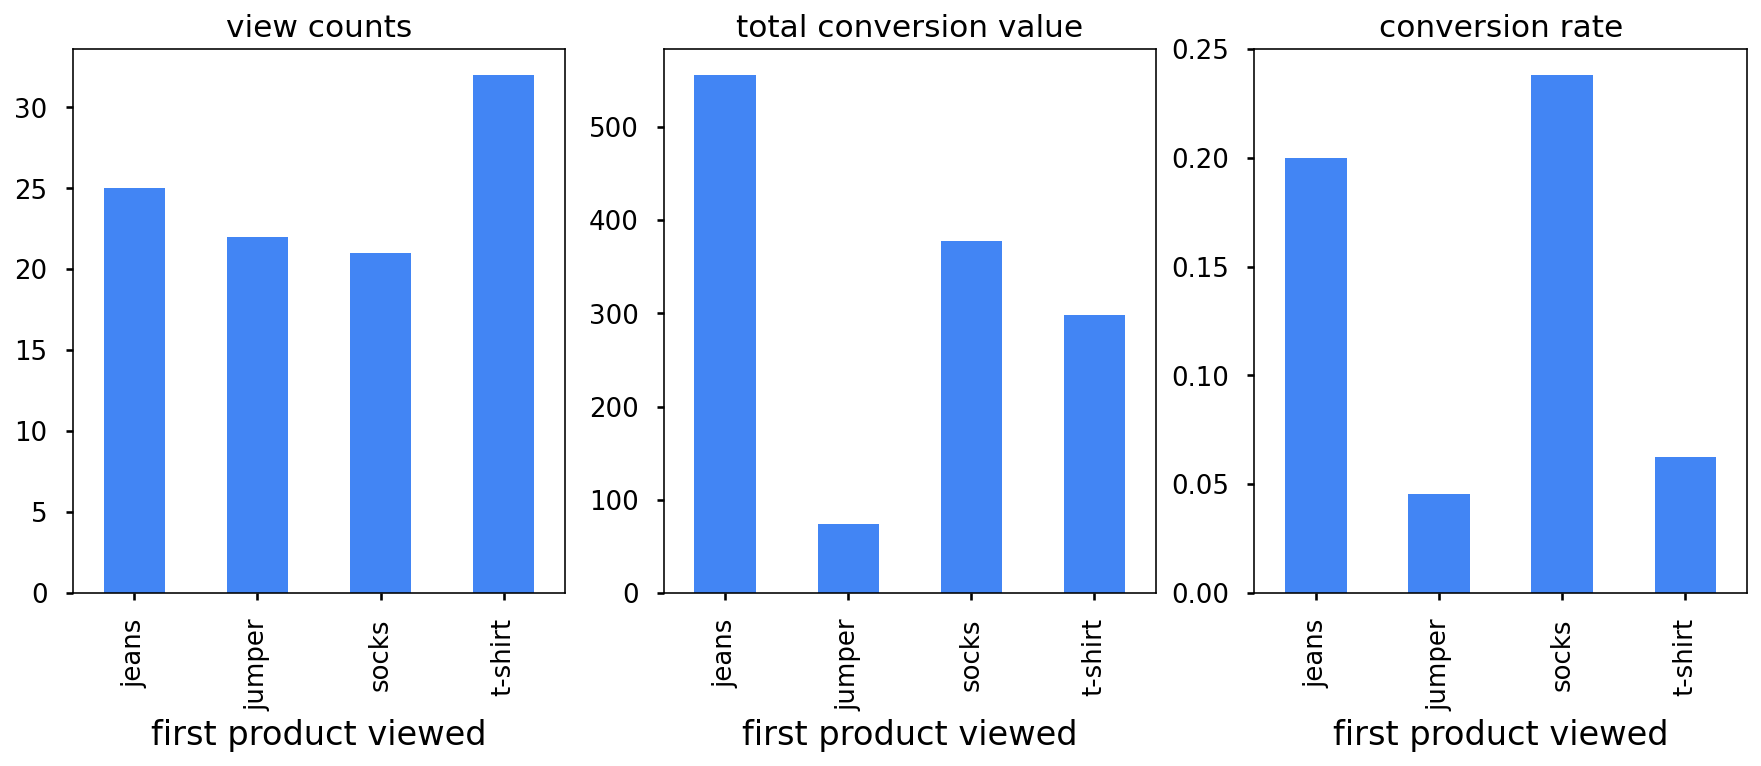

In [11]:
#@title
_, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
conversion_metrics['view_counts'].plot(
    kind='bar', title='view counts', xlabel='first product viewed', ax=axes[0])
conversion_metrics['total_conversion_value'].plot(
    kind='bar',
    title='total conversion value',
    xlabel='first product viewed',
    ax=axes[1])
conversion_metrics['conversion_rate'].plot(
    kind='bar',
    title='conversion rate',
    xlabel='first product viewed',
    ax=axes[2])
plt.show()

As you learned earlier, these statistics can reveal information about individuals in your dataset. For instance, only one person converted after the person saw a jumper first. For 22 views, your conversion rate is approximately 0.05. Now you need to transform each bar chart into a private one.

3. Define your _privacy parameters_ with the `pipeline_dp.NaiveBudgetAccountant` class, and then specify the `epsilon` and `delta` arguments that you want to use for your analysis. 

   How you set these arguments depends on your particular problem. To  learn more about them, see [Optional: Tweak the privacy and utility parameters](#Optional-Tweak-the-privacy-and-utility-parameters). 
    
  This code snippet uses example values:

    ```
    budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1 
                                                          total_delta=1e-5)
    ```


4. Initialize the `LocalBackend` instance:

In [12]:
ops = pipeline_dp.LocalBackend()

  You can use the `LocalBackend` instance because you run this program locally without additional frameworks, such as Beam or Spark.



5. Initialize the `DPEngine` instance:

    ```
dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)
```

    PipelineDP lets you specify further parameters through the `pipeline_dp.AggregateParams` class, which affects the generation of your private statistics. 

    ```
params = pipeline_dp.AggregateParams(
     noise_kind=pipeline_dp.NoiseKind.LAPLACE,
     metrics=[pipeline_dp.Metrics.COUNT],
     max_partitions_contributed=1,
     max_contributions_per_partition=1)
```

6. Specify that you want to calculate the `count` metric and use the `LAPLACE` noise distribution.
7. Set the `max_partitions_contributed` argument to a `1` value.

    This argument bounds how many different visits a user can contribute. You expect users to visit the website once per day and you don’t care whether they visit it multiple times over the course of the day.

8. Set the `max_contributions_per_partitions` argument to a `1` value.

    This argument specifies how many contributions a single visitor can make to an individual partition or a product category in this case.

9. Create a `data_extractor` instance that specifies where to find the `privacy_id`, `partition`, and `value` fields. 

    Your code should look like this code snippet: 

In [13]:
def run_pipeline(data,
                 ops,
                 total_epsilon=1,
                 total_delta=1e-9,
                 public_partitions=None):
  """Calculates differentially private count.

  This function takes in the data and the initialised privacy backend, privacy 
  parameters and (optional) public partitions and calculates the differentially-
  private count.

  Args:
    data: Data to use for the count-calculation.
    ops: Initialised privacy backend.
    total_epsilon: Epsilon to use for the calculation.
    total_delta: Delta to use for the calculation.
    public_partitions: If defined, will used those as public partitions in the
      private count calculation.
  """
  budget_accountant = pipeline_dp.NaiveBudgetAccountant(
      total_epsilon=total_epsilon, total_delta=total_delta)

  dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

  params = pipeline_dp.AggregateParams(
      noise_kind=pipeline_dp.NoiseKind.LAPLACE,
      metrics=[pipeline_dp.Metrics.COUNT],
      max_partitions_contributed=1,
      max_contributions_per_partition=1)

  data_extractors = pipeline_dp.DataExtractors(
      privacy_id_extractor=lambda row: row.user_id,
      partition_extractor=lambda row: row.product_view_0,
      value_extractor=lambda row: row.has_conversion)

  dp_result = dp_engine.aggregate(data, params, data_extractors, public_partitions)

  budget_accountant.compute_budgets()

  return dp_result

10. Add this code to transform your Pandas DataFrame into a list of rows from which you can directly calculate differentially private statistics:


In [14]:
rows = [index_row[1] for index_row in df.iterrows()]

dp_result_local = run_pipeline(
    rows, ops, total_epsilon=EPSILON, total_delta=DELTA)  # returns generator
dp_result_local = list(dp_result_local)

Congratulations! You calculated your first differentially private statistic!

This chart shows the result of your differentially private count next to the non-private count that you calculated earlier:

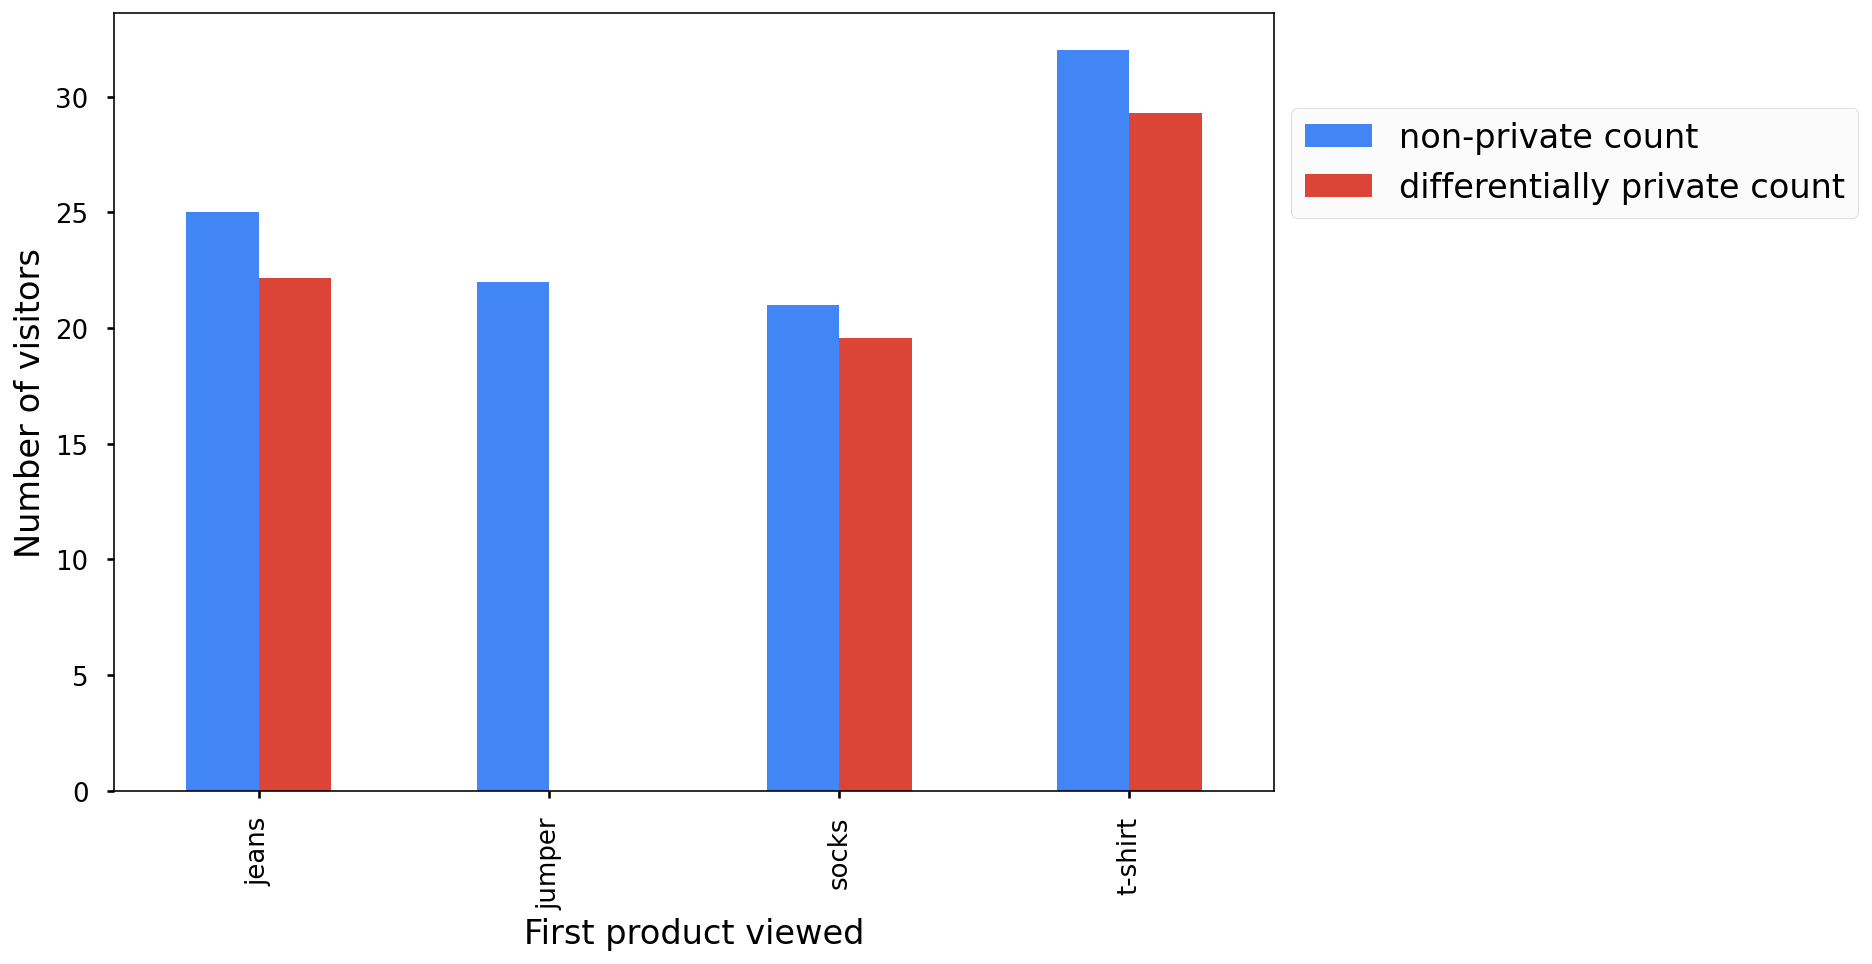

In [15]:
#@title
dp_result_local = private_result_to_df(
    dp_result=dp_result_local, metrics=['count'])
_, ax = plt.subplots()
ax = plot_private_and_standard_statistics(
    df=df['product_view_0'].value_counts().sort_index(),
    dp_result=dp_result_local,
    private_metric_name='count',
    original_metric_name='product_view_0',
    ax=ax,
    y_label='Number of visitors')
plt.show()

The bar chart that you get when you run the code might differ from this one, which is okay. Due to the noise in differential privacy, you get a different bar chart each time that you run the code, but you can see that they're similar to the original non-private bar chart.

Please note that it's very important for the privacy guarantees to not run the pipeline multiple times for the sake of privacy guarantees. For more information, see [Compute multiple statistics](#compute-multiple-statistics).


# Use public partitions

Duration: 7:00

In the previous section, you might have noticed that you dropped all visits data for a partition, namely visitors that first saw socks on your website. 

This is due to partition selection or thresholding, an important step to ensure differential-privacy guarantees when the existence of output partitions depends on the user data itself. When this is the case, the mere existence of a partition in the output can leak the existence of an individual user in the data. To learn more about why this violates privacy, see [this blog post](https://desfontain.es/privacy/almost-differential-privacy.html). To prevent this privacy violation, PipelineDP only keeps partitions with a sufficient number of users in them.

When the list of output partitions doesn't depend on private user data, you don’t need this partition-selection step. This is actually the case for your example because you know all possible product categories that a customer could see first.

To use partitions:

1. Create a list of your possible partitions:


In [16]:
public_partitions_products = ['jeans', 'jumper', 'socks', 't-shirt']

2. Pass the list to the `run_pipeline()` function: 

In [17]:
ops = pipeline_dp.LocalBackend()
dp_result_local_w_public_partitions = run_pipeline(
    rows, ops,
    total_epsilon=EPSILON,
    total_delta=0,
    public_partitions=public_partitions_products)  # returns generator

  This sets it as an additional input to the `pipeline_dp.AggregateParams` class:

```
params = pipeline_dp.AggregateParams(
     noise_kind=pipeline_dp.NoiseKind.LAPLACE,
     metrics=[pipeline_dp.Metrics.COUNT],
     max_partitions_contributed=1,
     max_contributions_per_partition=1)
```

  If you use public partitions and `LAPLACE` noise, it's possible to set the `total_delta` argument to a `0` value.

  Now you see in the result that data for all partitions, or products, is reported.

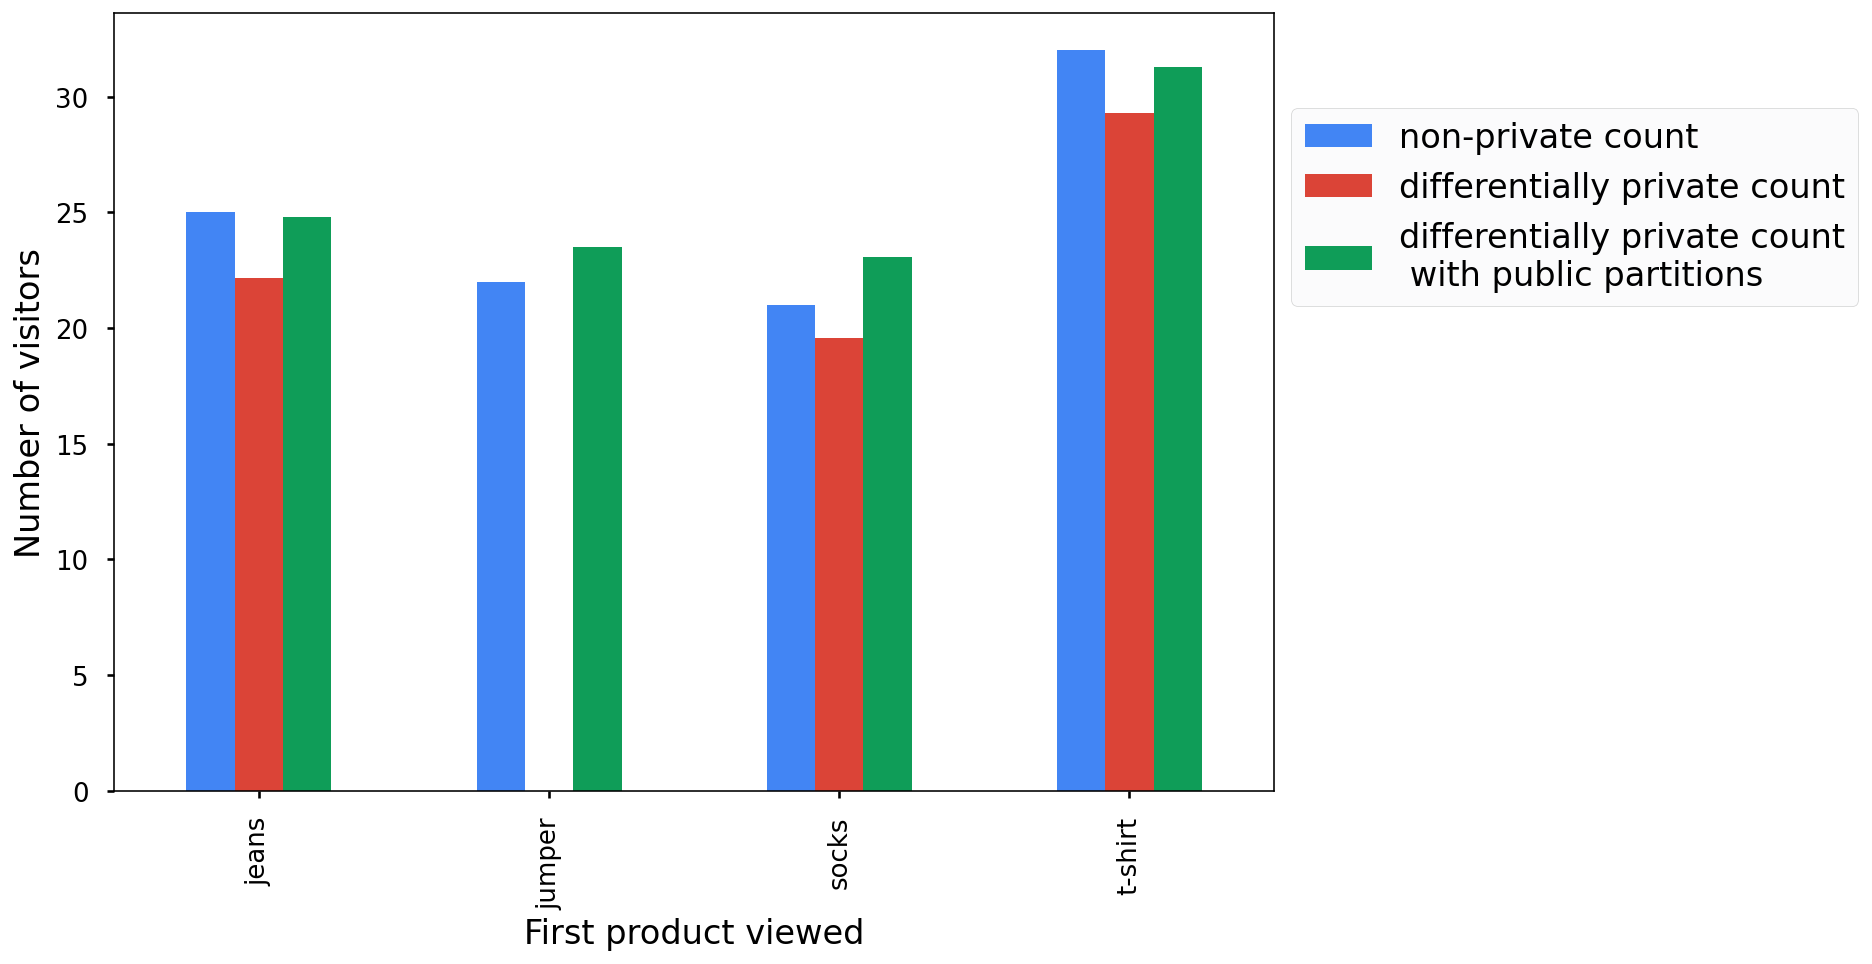

In [18]:
#@title
dp_result_local_w_public_partitions = private_result_to_df(
    dp_result=list(dp_result_local_w_public_partitions), metrics=['count'])

comparison_private_counts_public_partitions = pd.merge(
    dp_result_local.rename({'count': 'differentially private count'}, axis=1),
    dp_result_local_w_public_partitions.rename(
        {'count': 'differentially private count\n with public partitions'},
        axis=1),
    left_index=True,
    right_index=True,
    how='outer')
comparison_private_counts_public_partitions = pd.merge(
    df['product_view_0'].value_counts().sort_index().rename(
        'non-private count', inplace=True),
    comparison_private_counts_public_partitions,
    left_index=True,
    right_index=True,
    how='outer')

ax = comparison_private_counts_public_partitions.plot(kind='bar')
ax.legend(bbox_to_anchor=[1, 0.9])
ax.set_ylabel('Number of visitors')
ax.set_xlabel('First product viewed')
plt.show()

Not only do public partitions let you keep more partitions, but they also add roughly half as much noise because you don't spend any privacy budget on partition selection, so the difference between raw and private counts is slightly less compared to the previous run.

There are two important things to keep in mind when you use public partitions:



* Be careful when you derive the list of partitions from raw data. If you don't do this in a differentially private way, your pipeline no longer provides differential privacy guarantees. For more information, see [Advanced: Derive partitions from data](#advanced-derive-partitions-from-data).
* If there's no data for some of the public partitions, you need to apply noise to those partitions to preserve differential privacy. For example, if you used an additional product like trousers, which doesn’t occur in your dataset or on your website, it's still noise and the results might show some visits to products when there were none.


## Advanced: Derive partitions from data

If you run multiple aggregations with the same list of non-public output partitions in the same pipeline, you can derive the list of partitions once with the `dp_engine.select_private_partitions() `method and supply the partitions to each aggregation as the `public_partitions` input. Not only is this safe from a privacy perspective, but it also lets you add less noise because you only use the privacy budget on partition selection _once_ for the entire pipeline.

In [19]:
def get_private_product_views(data, ops):
  """Obtains the list of product_views in a private manner.

    This does not calculate any private metrics; it merely obtains the list of
    product_views but does so making sure the result is differentially private.
  
  Args:
    data: Data to derive public partitions from.
    ops: Initialised privacy backend.
  """

  # Set the total privacy budget.
  budget_accountant = pipeline_dp.NaiveBudgetAccountant(
      total_epsilon=EPSILON, total_delta=DELTA)

  # Create a DPEngine instance.
  dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

  # Specify how to extract privacy_id, partition_key and value from a single
  # element.
  data_extractors = pipeline_dp.DataExtractors(
      partition_extractor=lambda row: row.product_view_0,
      privacy_id_extractor=lambda row: row.user_id)

  # Run aggregation.
  dp_result = dp_engine.select_partitions(
      data,
      pipeline_dp.SelectPartitionsParams(max_partitions_contributed=1),
      data_extractors=data_extractors)

  budget_accountant.compute_budgets()
  return dp_result

# Compute multiple statistics 

Duration: 12:00

Now that you know how PipelineDP works, you can see how you can use it for some more advanced use cases. As mentioned at the beginning, you're interested in three statistics. PipelineDP lets you compute multiple statistics at the same time as long as those share the same parameters in the `AggregateParams` instance, which you see later. Not only is it cleaner and easier to calculate multiple metrics in one go, it's also better in terms of privacy. 

If you remember the `epsilon` and `delta` parameters that you supply to the `NaiveBudgetAccountant` class, they represent something called a _privacy budget_, which is a measure of the amount of user privacy that you leak from the data.

An important thing to remember about the privacy budget is that it's additive. If you run a pipeline with a particular epsilon ε and delta δ a single time, you spend an (ε,δ) budget. If you run it a second time, you spend a total budget of (2ε, 2δ). Similarly, if you compute multiple statistics with a `NaiveBudgetAccountant` method and consecutively a privacy budget of ε,δ, you spend a total budget of (2ε, 2δ). This means that you degrade the privacy guarantees.

To circumvent this, you need to use a single `NaiveBudgetAccountant` instance with the total budget that you want to use when you need to compute multiple statistics over the same data. You then need to specify the `epsilon` and `delta` values that you want to use for each aggregation. In the end, you end up with the same overall privacy guarantee, but the higher `epsilon` and `delta` values that a particular aggregation has, the higher accuracy it has.

To see this in action, you can compute the `count`, `mean`, and `sum` statistics. 

You calculate statistics on top of two different metrics: a `conversion_value` metric, which you use to infer the amount of revenue generated based on which product is viewed first, and a `has_conversion` metric, which you use to calculate the number of visitors to your website and the average conversion rate. 

For each metric, you need to separately specify the parameters that guide the calculation of the private statistics. You split your privacy budget across the two metrics. You calculate two statistics from the `has_conversion` metric, so you want to assign it two-thirds of your initial budget and assign the other one-third to the `conversion_value` metric. 

To compute multiple statistics:


1. Set up your privacy budget accountant with the total `epsilon` and `delta` values that you want to use across the three statistics:

    ```
budget_accountant = pipeline_dp.NaiveBudgetAccountant(
     total_epsilon=1, total_delta=0)
```


2. Initialize the `DPEngine` to calculate your metrics:

    ```
 dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)
```


3. Specify the parameters to calculate the total conversion value.

    ```
 params_conversion_value_metrics = pipeline_dp.AggregateParams(
     noise_kind=pipeline_dp.NoiseKind.LAPLACE,
     metrics=[pipeline_dp.Metrics.SUM],
     max_partitions_contributed=1,
     max_contributions_per_partition=1,
     min_value=0,
     max_value=100,
     budget_weight=1/3)
```

    The last argument optionally specifies the weight of your privacy budget.  You could give the same weight to all, but you want to set this argument to one-third as explained earlier. 

    You also set a `min_value` and `max_value` argument to specify the lower and upper bound applied to a value contributed by a unit of privacy in a partition. These parameters are required when you want to calculate a private sum or mean. You don’t expect negative values, so you can assume `0` and `100` as reasonable bounds.


4. Extract the relevant data and then pass it to the aggregation function:

    ```
 data_extractors_conversion_value_metrics = pipeline_dp.DataExtractors(
     privacy_id_extractor=lambda row: row.user_id,
     partition_extractor=lambda row: row.product_view_0,
     value_extractor=lambda row: row.conversion_value)

 dp_result_conversion_value_metrics = (
     dp_engine.aggregate(data, params_conversion_value_metrics,
         data_extractors_conversion_value_metrics,
         public_partitions_products))
```


5. Follow the same steps to calculate the two metrics based on your `has_conversion` variable: 

     ```
params_conversion_rate_metrics = pipeline_dp.AggregateParams(
     noise_kind=pipeline_dp.NoiseKind.LAPLACE,
     metrics=[pipeline_dp.Metrics.COUNT, pipeline_dp.Metrics.MEAN],
     max_partitions_contributed=1,
     max_contributions_per_partition=1,
     min_value=0,
     max_value=1,
     budget_weight=2/3)
     ```
     ```
 data_extractors_conversion_rate_metrics = pipeline_dp.DataExtractors(
     privacy_id_extractor=lambda row: row.user_id,
     partition_extractor=lambda row: row.product_view_0,
     value_extractor=lambda row: row.has_conversion)
     ```
     ```
 dp_result_conversion_rate_metrics = (
     dp_engine.aggregate(
         data, params_conversion_rate_metrics,
         data_extractors_conversion_rate_metrics,
         public_partitions_products))
```

    The only change is in the `pipeline_dp.AggregateParams` instance, in which you now define `mean` and `count` as aggregations, and assign two-thirds of your privacy budget to this calculation. Because you want to have the same contribution bounds for both statistics and calculate them on top of the same `has_conversion` variable, you can combine them in the same `pipeline_dp.AggregateParams` instance and calculate them at the same time.


6. Call the `budget_accountant.compute_budgets()` method:

    ```
budget_accountant.compute_budgets()
```

You can plot all three private statistics in comparison to their original statistics. Depending on the noise added, you see that the results can actually fall outside of the plausible scale. In this instance, you see a negative conversion rate and total conversion value for jumpers because the noise added is symmetric around zero. For further analyses and processing, it's best to not manually post-process the private statistics, but if you wanted to add those plots to a report, you could simply set the minimum to zero afterward without violation of the privacy guarantees. 



In [20]:
#@markdown ###Function to calculate multiple statistics
def run_pipeline_multiple_statistics(data,
                                     ops,
                                     total_epsilon=EPSILON,
                                     total_delta=DELTA,
                                     public_partitions=None):
  """Calculates three differentially private statistics.

  This function takes in the data and the initialised privacy backend, privacy 
  parameters and (optional) public partitions and calculates the differentially-
  private count, sum, and mean.

  Args:
    data: Data to use for the count-calculation.
    ops: Initialised privacy backend.
    total_epsilon: Epsilon to use for the calculation.
    total_delta: Delta to use for the calculation.
    public_partitions: If defined, will used those as public partitions in the
      private count calculation.
  """

  budget_accountant = pipeline_dp.NaiveBudgetAccountant(
      total_epsilon=total_epsilon, total_delta=total_delta)

  dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

  params_conversion_value_metrics = pipeline_dp.AggregateParams(
      noise_kind=pipeline_dp.NoiseKind.LAPLACE,
      metrics=[pipeline_dp.Metrics.SUM],
      max_partitions_contributed=1,
      max_contributions_per_partition=1,
      min_value=0,
      max_value=100,
      budget_weight=1/3)

  data_extractors_conversion_value_metrics = pipeline_dp.DataExtractors(
      privacy_id_extractor=lambda row: row.user_id,
      partition_extractor=lambda row: row.product_view_0,
      value_extractor=lambda row: row.conversion_value)

  dp_result_conversion_value_metrics = (
      dp_engine.aggregate(data, params_conversion_value_metrics,
          data_extractors_conversion_value_metrics, public_partitions))

  params_conversion_rate_metrics = pipeline_dp.AggregateParams(
      noise_kind=pipeline_dp.NoiseKind.LAPLACE,
      metrics=[pipeline_dp.Metrics.COUNT, pipeline_dp.Metrics.MEAN],
      max_partitions_contributed=1,
      max_contributions_per_partition=1,
      min_value=0,
      max_value=1,
      budget_weight=2/3)

  data_extractors_conversion_rate_metrics = pipeline_dp.DataExtractors(
      privacy_id_extractor=lambda row: row.user_id,
      partition_extractor=lambda row: row.product_view_0,
      value_extractor=lambda row: row.has_conversion)

  dp_result_conversion_rate_metrics = (
      dp_engine.aggregate(data, params_conversion_rate_metrics,
          data_extractors_conversion_rate_metrics, public_partitions))

  budget_accountant.compute_budgets()

  return dp_result_conversion_value_metrics, dp_result_conversion_rate_metrics

In [21]:
#@markdown ###Calculate all 3 statistics

ops = pipeline_dp.LocalBackend()
dp_result_conversion_value_metrics, dp_result_conversion_rate_metrics = run_pipeline_multiple_statistics(
    rows,
    ops,
    total_epsilon=EPSILON,
    total_delta=0,
    public_partitions=public_partitions_products)  # returns generator

dp_result_conversion_value_metrics = list(dp_result_conversion_value_metrics)
dp_result_conversion_rate_metrics = list(dp_result_conversion_rate_metrics)

dp_result_conversion_rate_metrics = private_result_to_df(
    dp_result_conversion_rate_metrics, metrics=['mean', 'count'])
dp_result_conversion_value_metrics = private_result_to_df(
    dp_result_conversion_value_metrics, metrics=['sum'])
all_private_statistics = pd.merge(
    dp_result_conversion_rate_metrics,
    dp_result_conversion_value_metrics,
    right_index=True,
    left_index=True,
    how='outer')

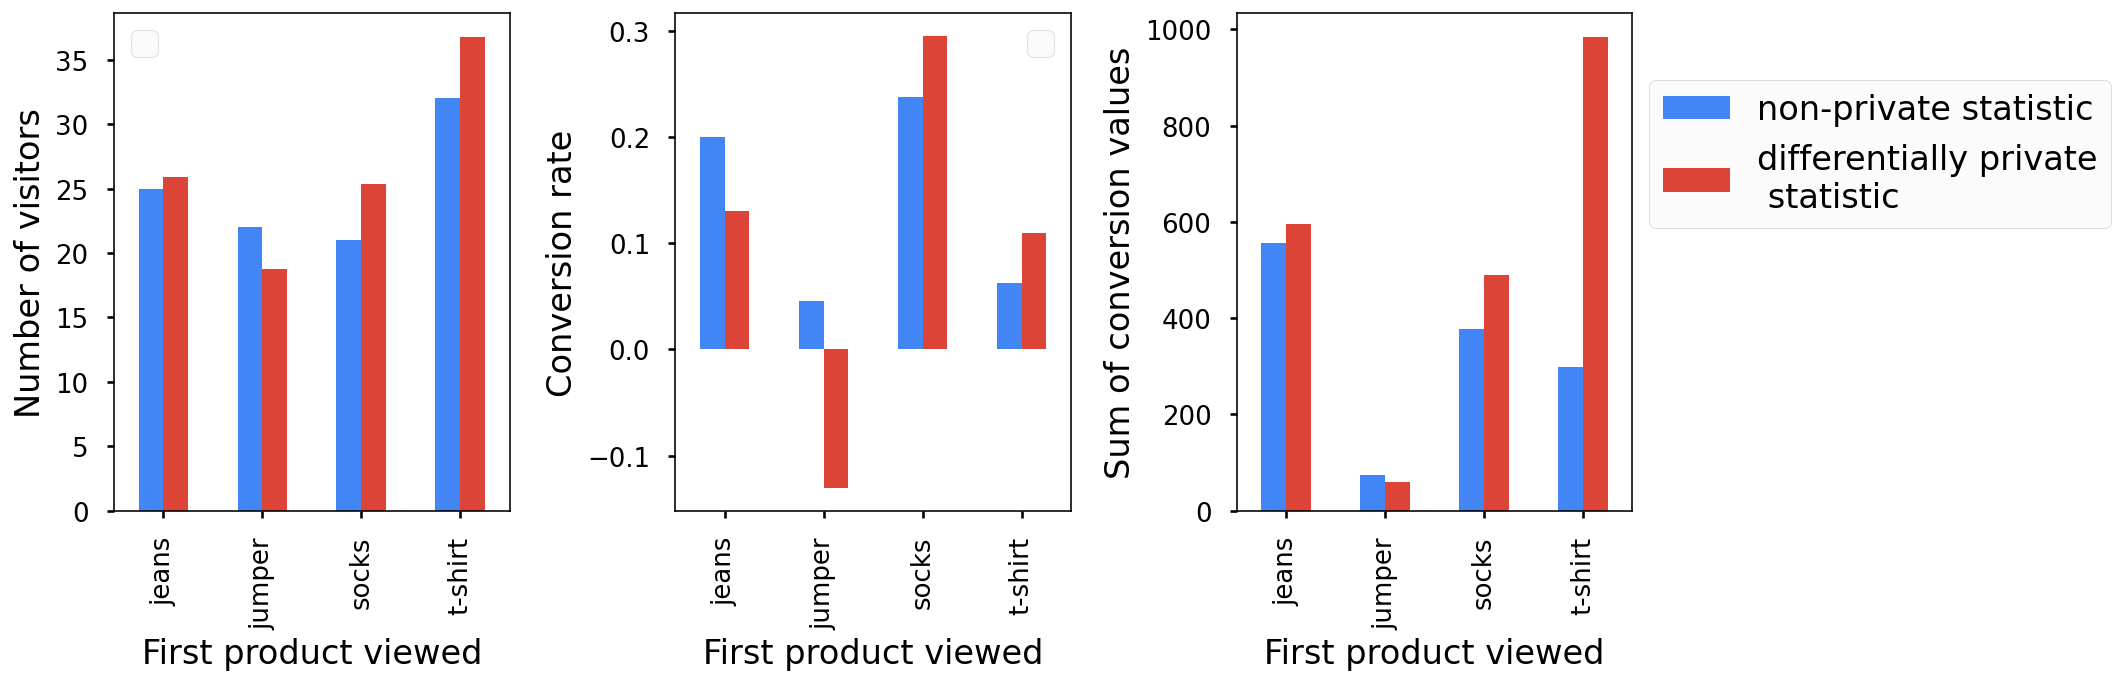

In [22]:
#@markdown ###Plot all 3 statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

axes[0] = plot_private_and_standard_statistics(
    df=conversion_metrics['view_counts'],
    dp_result=all_private_statistics,
    private_metric_name='count',
    original_metric_name='view_counts',
    ax=axes[0],
    y_label='Number of visitors')
axes[0].legend('')

axes[1] = plot_private_and_standard_statistics(
    df=conversion_metrics['conversion_rate'],
    dp_result=all_private_statistics,
    private_metric_name='mean',
    original_metric_name='conversion_rate',
    ax=axes[1],
    y_label='Conversion rate')
axes[1].legend('')

axes[2] = plot_private_and_standard_statistics(
    df=conversion_metrics['total_conversion_value'],
    dp_result=all_private_statistics,
    private_metric_name='sum',
    original_metric_name='total_conversion_value',
    ax=axes[2],
    y_label='Sum of conversion values')
axes[2].legend(['non-private statistic', 'differentially private\n statistic'],
               bbox_to_anchor=(1, 0.9))
fig.tight_layout()

# Run the pipeline with Beam 

Duration: 8:00

Data processing nowadays requires you to deal with huge amounts of data, so much so that you can't process it locally. Instead, many people use frameworks for large-scale data processing, such as Beam or Spark, and run their pipelines in the cloud.

PipelineDP supports Beam and Spark with only small changes to your code.

To run the pipeline with Beam with the `private_beam` API:


1. Initialize a `runner` variable and then create a pipeline in which you apply your privacy operations to a Beam representation of your `rows`:

    ```
runner = fn_api_runner.FnApiRunner()  # local runner

  with beam.Pipeline(runner=runner) as pipeline:
     beam_data = pipeline | beam.Create(rows)
```


2. Create a `budget_accountant` variable with your required privacy parameters:

    ```
budget_accountant = pipeline_dp.NaiveBudgetAccountant(
               total_epsilon=1, total_delta=0)
```

3. Create a `pcol`, or private collection, variable, which guarantees that any aggregations conform with your privacy requirements:

    ```
pcol = beam_data | pbeam.MakePrivate(
                                 budget_accountant=budget_accountant,
                                 privacy_id_extractor=lambda row: row.user_id)
```


4. Specify the parameters of your private aggregation in the appropriate class. 

    Here, you use the  `pipeline_dp.aggregate_params.SumParams()`class because you calculate the sum of product views.

5. Pass your aggregation parameters to `pbeam.Sum` method to calculate your statistic:

    ```
dp_result = pcol | pbeam.Sum(params)
```


6. In the end, your code should look like this code snippet:

In [23]:
runner = fn_api_runner.FnApiRunner()  # local runner

with beam.Pipeline(runner=runner) as pipeline:
  beam_data = pipeline | beam.Create(rows)
  budget_accountant = pipeline_dp.NaiveBudgetAccountant(
      total_epsilon=EPSILON, total_delta=0)

  # Create PrivatePCollection
  pcol = beam_data | pbeam.MakePrivate(
      budget_accountant=budget_accountant,
      privacy_id_extractor=lambda row: row.user_id)

  # Create params for counts
  params = pipeline_dp.aggregate_params.CountParams(
      noise_kind=pipeline_dp.aggregate_params.NoiseKind.LAPLACE,
      max_partitions_contributed=1,
      max_contributions_per_partition=1,
      partition_extractor=lambda row: row.product_view_0)

  dp_result = pcol | pbeam.Count(params, public_partitions=public_partitions_products)

  budget_accountant.compute_budgets()

  dp_result | beam.Map(print)

('jeans', 24.555229404937563)
('jumper', 23.862300154186414)
('socks', 20.995994513803453)
('t-shirt', 31.50921557427955)


In [24]:
#@markdown ## Optional: using framework-independent functions with Beam
runner = fn_api_runner.FnApiRunner()  # local runner

with beam.Pipeline(runner=runner) as pipeline:
  beam_data = pipeline | beam.Create(rows)
  ops = pipeline_dp.BeamBackend()
  public_partitions_product_views = get_private_product_views(beam_data, ops)
  dp_result = run_pipeline(
      beam_data,
      ops,
      total_epsilon=EPSILON,
      total_delta=DELTA,
      public_partitions=public_partitions_product_views)
  dp_result | beam.Map(print)

('jeans', MetricsTuple(count=27.559514394141843))
('t-shirt', MetricsTuple(count=31.713486223631662))
('jumper', MetricsTuple(count=21.82038761243166))
('socks', MetricsTuple(count=23.171469124919895))


# Optional: Tweak the privacy and utility parameters
Duration: 5:00

You've seen quite a few parameters mentioned in this codelab, such as the `epsilon`, `delta`, and  `max_partitions_contributed` parameters. You can roughly divide them into two categories: _privacy parameters_ and _utility parameters_.


### Privacy parameters 

The `epsilon` and `delta` parameters quantify the privacy that you provide with differential privacy. More precisely, they're a measure of how much information a potential attacker can gain about the data from the anonymized output. The higher the value of the parameters, the more information the attacker gains about the data, which is a privacy risk. On the other hand, the lower the value of the `epsilon` and `delta` parameters, the more noise you need to add to the output to make it anonymous and the higher the number of unique users that you need in each partition to keep them in the anonymized output. In this case, there's a tradeoff between utility and privacy.

In PipelineDP, you need to specify your desired privacy guarantees of your anonymized output when you set the total privacy budget in the `NaiveBudgetAccountant` instance. The caveat is that if you want your privacy guarantees to hold, you need to carefully use a separate `NaiveBudgetAccountant` instance for each aggregation or run the pipeline multiple times to avoid the overuse of your budget.

For more information about differential privacy and what the privacy parameters mean, see [A reading list on differential privacy](https://desfontain.es/privacy/differential-privacy-reading-list.html).


### Utility parameters 

Utility parameters don't affect the privacy guarantees, but affect the accuracy and, consequently, the utility of the output. They're provided in the `AggregateParams` instance and used to scale the noise added.

A utility parameter provided in the `AggregateParams` instance and applicable to all aggregations is the `max_partitions_contributed` parameter. A partition corresponds to a key of the data that's returned by the PipelineDP aggregation operation, so the` max_partitions_contributed` parameter bounds the number of distinct key values that a user can contribute to the output. If a user contributes to a number of keys that exceeds the value of the `max_partitions_contributed` parameter, some contributions are dropped so that they contribute to the exact value of the `max_partitions_contributed` parameter.

Similarly, most aggregations have a `max_contributions_per_partition` parameter. They're also provided in the `AggregateParams` instance` `and each aggregation could have separate values for them. They bound a user’s contribution for each key.

The noise added to the output is scaled by the `max_partitions_contributed` and `max_contributions_per_partition` parameters, so there's a tradeoff here: Larger values assigned to each parameter means that you keep more data, but you get a noisier result.

Some aggregations require a `min_value` and `max_value` parameter, which specify the bounds for contributions of each user. If a user contributes a value lower than the value assigned to the `min_value` parameter, the value is increased to the value of the parameter. Similarly, if a user contributes a value larger than the value of the `max_value` parameter, the value is decreased to the value of the parameter. To keep more of the original values, you have to specify larger bounds. Noise is scaled by the size of the bounds, so larger bounds let you keep more data, but you end up with a noisier result.

Finally, the `noise_kind` parameter supports two different noise mechanisms in PipelineDP: `GAUSSIAN` and `LAPLACE` noise. The `LAPLACE` distribution gives better utility with low contribution bounds, which is why PipelineDP uses it by default. However, if you want to use a `GAUSSIAN` distribution noise, you can specify it in the `AggregateParams` instance.


# Congratulations

Duration: 0:00

Great job! You finished the PipelineDP codelab and learned a lot about differential privacy and PipelineDP.


## Learn more 
*   [GitHub repository](https://github.com/OpenMined/PipelineDP)

*   [PipelineDP](https://pipelinedp.io)

*   [Privacy on Beam codelab](https://codelabs.developers.google.com/codelabs/privacy-on-beam#0)
